# Behavioral Analysis for Wolbachia Experiment

## Imports and functions

In [85]:
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from unityvr.preproc import logproc as lp
from unityvr.analysis import posAnalysis
from unityvr.viz import viz, utils

### Util Functions

In [86]:
def select_file_path(prompt="Select File", initialdir=r"Z:\FlyVR\FlyVR data"):
    root = tk.Tk()
    root.withdraw()
    root.attributes("-topmost", 1)

    file_path_str = filedialog.askopenfilename(title=prompt, initialdir=initialdir)
    if file_path_str == "":
        print("File selection canceled")
        return None
    file_path = Path(file_path_str)
    return file_path

In [87]:
def select_folder_str(prompt="Select Folder"):
    root = tk.Tk()
    root.withdraw()
    root.attributes("-topmost", 1)

    dir_path_str = filedialog.askdirectory(title=prompt)
    return dir_path_str

### Plotting Functions

In [88]:
def plot_path(ax, uvr, cax=None):
    # plot path on given axes
    convfac = 10 # dc2cm

    # Plot path
    ax.plot(uvr.posDf.x*convfac,uvr.posDf.y*convfac,color='grey', linewidth=0.5)
    # Plot head direction at each point
    cb = ax.scatter(uvr.posDf.x*convfac,uvr.posDf.y*convfac,s=5,c=uvr.posDf.angle, cmap='hsv')
    
    # Draw start point
    ax.plot(uvr.posDf.x[0]*convfac,uvr.posDf.y[0]*convfac,'ok')
    # Draw start text
    ax.text(uvr.posDf.x[0]*convfac+0.2,uvr.posDf.y[0]*convfac+0.2,'start')
    # Draw end point
    ax.plot(uvr.posDf.x.values[-1]*convfac,uvr.posDf.y.values[-2]*convfac,'sk')

    plt.colorbar(cb, cax=cax, ax=ax, label='head direction [degree]', pad=0.01, location='top')

    # Pick point close to bottom left of panel to place scale bar
    scale_bar_pos = [None]*2
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    scale_bar_pos[0] = (xlim[1] - xlim[0])* 0.1 + xlim[0]
    scale_bar_pos[1] = (ylim[1] - ylim[0])* 0.1 + ylim[0]
    utils.plotScaleBar(ax,xlen=1,pos=scale_bar_pos,labeltext='1 cm')

    # Create legend for start and end point
    # start_point = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
    #                       markersize=8, label='Start')
    # end_point = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
    #                       markersize=8, label='End')
    # ax.legend(handles=[start_point, end_point])

    ax.set_xlabel("Fly Path")

    ax.set_aspect('equal')

def plot_dark_stim(uvr, fig=None, figsize=None):
    # Plot rotational and forward velocity histograms and fly path
    # Check if uvr object has computed velocities, if not compute them
    if not {'vT', 'vR'}.issubset(uvr.posDf.columns):
        posAnalysis.computeVelocities(uvr.posDf)

    # Create mosaic for plot layout
    mosaic = [['path', 'hist_forw'],
              ['path', 'hist_rot']]
    gridspec_kw = {"hspace": 0.3, "wspace": 0.35}
    if fig is None:
        fig, axd = plt.subplot_mosaic(mosaic, figsize=figsize,
                                      gridspec_kw=gridspec_kw)
    else:
        axd = fig.subplot_mosaic(mosaic,
                                 gridspec_kw=gridspec_kw)

    # Plot fly path
    plot_path(axd['path'], uvr)

    # Plot forward velocity
    axd['hist_forw'].hist(uvr.posDf.vT, bins=21, range=(0,6))
    axd['hist_forw'].set_xlabel("Forward Velocity (cm/s)")
    axd['hist_forw'].set_ylabel("Counts")

    # Plot rotational velocity
    axd['hist_rot'].hist(uvr.posDf.vR, bins=21, range=(-3,3))
    axd['hist_rot'].set_xlabel("Rotational Velocity (°/s)")
    axd['hist_rot'].set_ylabel("Counts")

    fig.suptitle("Dark Condition")

    if fig is None:
        return fig, axd
    else:
        return axd

def plot_grating_stim(uvr, fig=None, figsize=None):
    # Plot rotational velocity histograms for each stimuli speed and plot fly path

    # Check if uvr object has computed velocities, if not compute them
    if not {'vT', 'vR'}.issubset(uvr.posDf.columns):
        posAnalysis.computeVelocities(uvr.posDf)
    # Check if uvr object has derived head angle in rads, if not compute them
    if 'radangle' not in uvr.posDf.columns:
        posAnalysis.position(uvr, derive=True)
    # Check if unwrapped angle included, if not compute it 
    if 'unwrapped_radangle' not in uvr.posDf.columns:
        uvr.posDf['unwrapped_radangle'] = np.unwrap(uvr.posDf.radangle)

    # Create mosaic for plot layout
    mosaic = [['path', 'angle_trace', 'angle_trace'],
              ['path', 'hist_rot', 'hist_forw']]
    gridspec_kw = {"hspace": 0.3, "wspace": 0.55,
                   "width_ratios": [2,1,1]}
    if fig is None:
        fig, axd = plt.subplot_mosaic(mosaic, figsize=figsize,
                                      gridspec_kw=gridspec_kw)
    else:
        axd = fig.subplot_mosaic(mosaic,
                                 gridspec_kw=gridspec_kw)
    
    # Plot fly path
    plot_path(axd['path'], uvr)

    # Plot angle over time
    axd['angle_trace'].plot(uvr.posDf.time, uvr.posDf.unwrapped_radangle)
    axd['angle_trace'].set_xticks(np.arange(0, uvr.posDf.time.iloc[-1]+1, 30))
    axd['angle_trace'].set_xlabel("Time (s)")
    axd['angle_trace'].set_ylabel("Head Angle (rad)")

    # Plot rotational velocity histogram
    axd['hist_rot'].hist(uvr.posDf.vR, bins=21, range=(-3,3))
    axd['hist_rot'].set_xlabel("Rotational Velocity (°/s)")
    axd['hist_rot'].set_ylabel("Counts")
    
    # Plot forward velocity histogram
    axd['hist_forw'].hist(uvr.posDf.vT, bins=21, range=(0,6))
    axd['hist_forw'].set_xlabel("Forward Velocity (cm/s)")
    axd['hist_forw'].set_yticks([])
    
    # Share y axis
    ylim_forw = axd['hist_forw'].get_ylim()
    ylim_rot = axd['hist_rot'].get_ylim()
    ylim = [min(ylim_forw[0], ylim_rot[0]), max(ylim_forw[1], ylim_rot[1])]

    axd['hist_forw'].set_ylim(ylim)
    axd['hist_rot'].set_ylim(ylim)

    fig.suptitle("Moving Grating Condition")

    if fig is None:
        return fig, axd
    else:
        return axd

def plot_closed_loop_stim(uvr, fig=None, figsize=None):
    # Plot angular head direction histogram and fly path
    
    # Check if uvr object has derived head angle in rads, if not compute them
    if 'radangle' not in uvr.posDf.columns:
        posAnalysis.position(uvr, derive=True)
    # Check if uvr object has computed velocities, if not compute them
    if not {'vT', 'vR'}.issubset(uvr.posDf.columns):
        posAnalysis.computeVelocities(uvr.posDf)

    # Create subplots
    if fig is None:
        fig = plt.figure(figsize=figsize)
    axd = {}
    axd['path'] = fig.add_subplot(1,2,1)
    axd['hist_angle'] = fig.add_subplot(1,2,2, 
                                        projection='polar', 
                                        theta_offset=np.pi/2)

    # Plot fly path
    plot_path(axd['path'], uvr)

    # Plot histogram of head direction when the fly is moving (filter out low velocity)
    radangle_filt = uvr.posDf[uvr.posDf['vT_filt'] > uvr.posDf['vT_filt'].quantile(0.25)]['radangle']

    counts, bins = np.histogram(radangle_filt, bins = int(360/15))
    axd['hist_angle'].bar(bins[:-1], counts, align='edge', width=np.diff(bins))

    axd['hist_angle'].set_xlabel("Head direction during movement")

    ## Set origin of hist so it looks like a donut
    axd['hist_angle'].set_rorigin(-1*max(counts))

    ## Set tick marks
    axd['hist_angle'].set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    axd['hist_angle'].set_thetalim(-np.pi, np.pi)

    yticks = range(0, round(max(counts), -3), 1000)
    axd['hist_angle'].set_yticks(yticks)

    fig.suptitle("Closed Loop Condition")

    if fig is None:
        return fig, axd
    else:
        return axd
    

## Select data files

In [89]:
# Select unity vr file from the dark trial segment
dark_stim_path = select_file_path(prompt="Select dark stim file")

In [90]:
# Select unity vr file from the grating trial segment
grating_stim_path = select_file_path(prompt="Select grating stim file", initialdir=dark_stim_path.parent)

In [91]:
# Select unity vr file from the closed loop trial segment
closed_loop_stim_path = select_file_path(prompt="Select closed loop stim file", initialdir=grating_stim_path.parent)

In [92]:
print("Data Files Chosen:")
print(f"Dark stimuli file: {dark_stim_path}")
print(f"Grating stimuli file: {grating_stim_path}")
print(f"Closed loop stimuli file: {closed_loop_stim_path}")

Data Files Chosen:
Dark stimuli file: Z:\FlyVR\FlyVR data\Edwin\2023-08-04\Back up (-)\Log_2023-08-04_16-38-09.json
Grating stimuli file: Z:\FlyVR\FlyVR data\Edwin\2023-08-04\Back up (-)\Log_2023-08-04_16-43-16.json
Closed loop stimuli file: Z:\FlyVR\FlyVR data\Edwin\2023-08-04\Back up (-)\Log_2023-08-04_16-48-53.json


## Parse Data

In [93]:
uvr_dict = {
    'dark_stim': lp.constructUnityVRexperiment(str(dark_stim_path.parent), dark_stim_path.name),
    'grating_stim': lp.constructUnityVRexperiment(str(grating_stim_path.parent), grating_stim_path.name),
    'closed_loop_stim': lp.constructUnityVRexperiment(str(closed_loop_stim_path.parent), closed_loop_stim_path.name)
}

correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.


## Show Length of Trials

In [94]:
for trial_type, uvr in uvr_dict.items():
    length = uvr.posDf.iloc[-1]['time']
    print(f"{trial_type} trial took {length:.3f} seconds to run ({length//60:.0f} minutes and {length%60:.3f} seconds)")


dark_stim trial took 298.936 seconds to run (4 minutes and 58.936 seconds)
grating_stim trial took 299.259 seconds to run (4 minutes and 59.259 seconds)
closed_loop_stim trial took 299.257 seconds to run (4 minutes and 59.257 seconds)


## Create Plots

In [95]:
outfolder = select_folder_str(prompt="Select Output Folder")

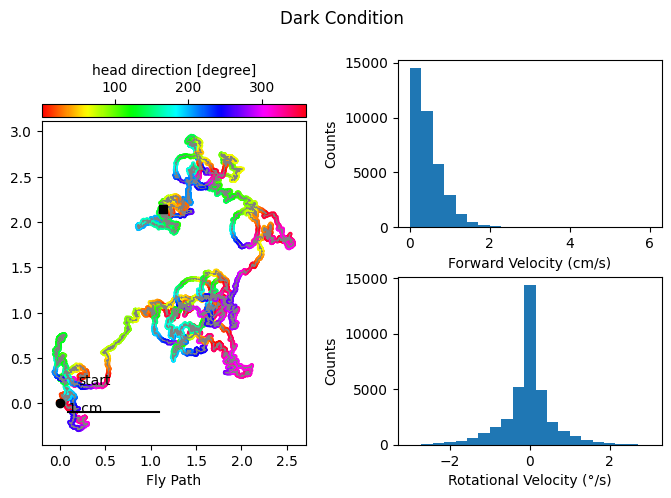

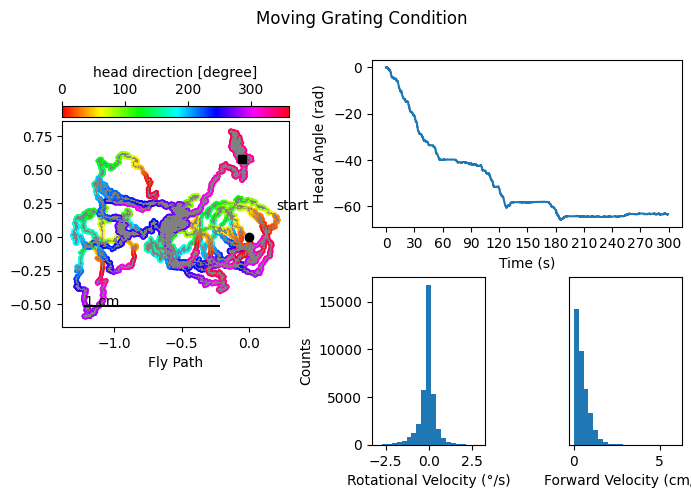

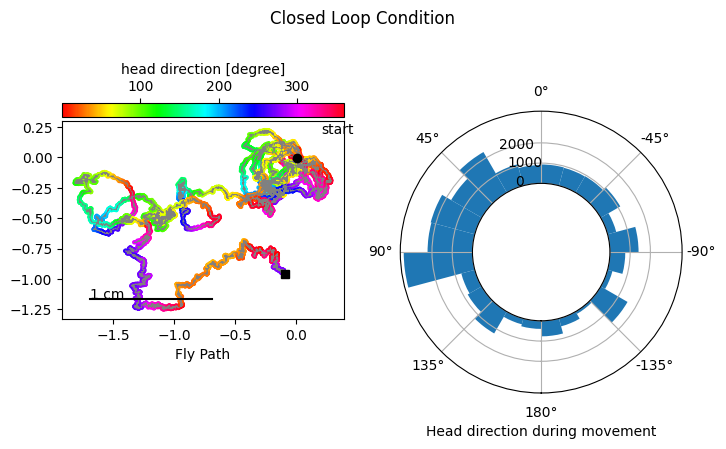

In [96]:
convfac = 10 # dc2cm

figsize = (8,5)

for index, (trial_type, uvr) in enumerate(uvr_dict.items()):
    fig = plt.figure(figsize=figsize)
    if trial_type == "dark_stim":
        plot_dark_stim(uvr, fig)
    if trial_type == "grating_stim":
        plot_grating_stim(uvr, fig)
    if trial_type == "closed_loop_stim":
        plot_closed_loop_stim(uvr, fig)
    file_name = f"{uvr.metadata['date']}_{uvr.metadata['time']}_{trial_type}"
    fig.savefig(Path(outfolder,file_name).with_suffix(".png"), dpi=600)
    fig.savefig(Path(outfolder,file_name).with_suffix(".svg"), dpi=600)

In [97]:
# dir_path_str = select_folder_str()
# filename = "trial_" + dark_stim_path.name.split('_')[1] + ".pdf"
# fig.savefig(Path(dir_path_str, filename), dpi=600)

## Check stimuli information

In [98]:
# uvr.posDf.describe()

In [99]:
# file_path = select_file_path(prompt="Select UnityVR Trial")
# uvr = lp.constructUnityVRexperiment(str(file_path.parent), file_path.name)

In [100]:
# stimuliDf = uvr.stmDf
# print(stimuliDf.head())

# fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.75})

# axs[0].plot(stimuliDf['rotSpeed'])
# axs[0].set_yticks(stimuliDf.drop_duplicates(subset=['rotSpeed'])['rotSpeed'])
# axs[0].set_xlabel("frame")
# axs[0].set_ylabel("rotational speed (deg/sec)")
# axs[0].set_title("Stimuli Speed")

# axs[1].plot(stimuliDf['azimuth'])
# axs[1].set_yticks(range(0,360+1,90))
# axs[1].set_xlabel("frame")
# axs[1].set_ylabel("stimuli position (deg)")
# axs[1].set_title("Stimuli Position")


## Test Plotting Functions

In [101]:
# radangle_filt = uvr.posDf[uvr.posDf['vT_filt'] > uvr.posDf['vT_filt'].quantile(0.25)]['radangle']
# plt.hist([uvr.posDf.radangle, radangle_filt], bins=360//15, label=['raw', 'filt'])
# plt.legend()

## Create plot all on one figure with same information for all conditions (better comparability)
Plotting for each condition should include fly path, angle over time, forward and rotational histograms, and head direction histogram.
Also need to create a function to check if fictrac failed in a trial. (can identify based on unrealistic velocities (filtered))

In [102]:
def get_fictrac_error_periods(uvr):
    # Given a uvr trial return periods where fictrac lost tracking

    # Check if uvr object has computed velocities, if not compute them
    if not {'vT', 'vR'}.issubset(uvr.posDf.columns):
        posAnalysis.computeVelocities(uvr.posDf)

    # Get periods where filtered velocity went above large value (examine a trial with lost tracking)
    return uvr.posDf[uvr.posDf['vT_filt'] > 100]

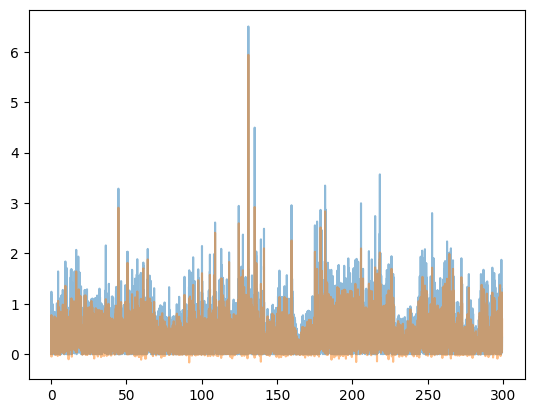

In [103]:
plt.plot(uvr_dict['closed_loop_stim'].posDf.time, uvr_dict['closed_loop_stim'].posDf.vT, alpha=0.5)
plt.plot(uvr_dict['closed_loop_stim'].posDf.time, uvr_dict['closed_loop_stim'].posDf.vT_filt, alpha=0.5)

In [104]:
get_fictrac_error_periods(uvr_dict['closed_loop_stim'])

,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt,ds,s,dTh,radangle,vT,vR,vT_filt,vR_filt


In [105]:
def plot_all_trial_data():
    # Given all three conditions from a trial,
    # Plot each condition with all types of information.
    
    pass